In [1]:
# import necessary library
import psycopg2
#import library pandas
import pandas as pd
#import library sqlio
import pandas.io.sql as sqlio

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)

#create database connection variable 
conn = psycopg2.connect(user="postgres", password="root1234", host="localhost", database="DVDRental")

#### What is Table:
 - table stores the db objects in the form of rows and columns.
 - depending upon the requirement, we choose the type to store data.

#### Types of tables:

1. Permanent table:
- default table
- content stored is persistant

2. Temporary table: 
- A temporary table is a short-lived table that exists for the duration of a database session or optionally at the end of the current transaction..
- PostgreSQL automatically drops the temporary tables at the end of a session or a transaction.
- Any index created on a temporary table are automatically temporary as well.

3. UNLOGGED table:
- Data written to the unlogged tables is not written to the **write-ahead log**. This makes them considerable faster than the ordinary tables.
- Unlogged tables are not crash-safe i.e. unlogged table is automatically truncated after a crash or unclean shutdown.
- Any indexes created on unlogged table are automatically unlogged as well.

**Write-ahead Log (WAL):**

In postgreSQL, transaction performed on the database is first written out as a WAL file and then applied to the actual on-disk table data files.

Everything related to database operations is logged in the WAL. In case of disaster, you would be able to recover the DB using WAL.

Write-ahead log (WAL) is a key-component of what makes Postgres reliable.

#### How to create Temporary and unlogged table

You can add a TEMPORARY or TEMP keyword to create a temporary table.
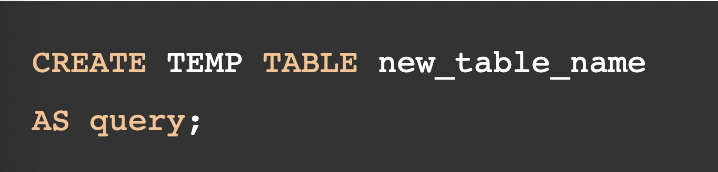
OR 
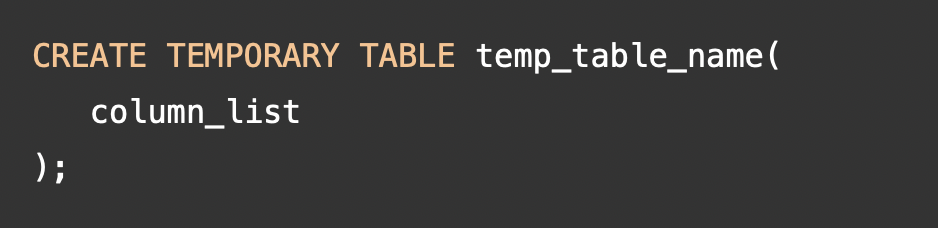

For demo:

1. Create a new table with the following DDL command

    CREATE TEMP TABLE mytemp(c INT);

2. Execute following command in the same SQL tab in which you created the table:
    select * from mytemp;

3. Open another SQL editor and execute 2nd command.
    select * from mytemp;
    
As you can see, the second session could not see mytemp table. Only the first session can access it.

Also, mytemp table will be automatically dropped if you close the SQL editor in which you created mytemp table.

Important Point: 
    A temporary table can share the same name with a permanent table (not recommended)
    
    When you create a temp table that has the same name as the permanent table, you can not access the permanent table untill the temporary table is removed.

Dropping a Temporary table:
    
    Syntex: DROP TABLE temp_table_name;
        
Unlike the CREATE TABLE statement, the DROP TABLE statement does not have the TEMP or TEMPORAY keyword created specifically for temporary tables.

**UNLOGGED** keyword is used to create an unlogged table.
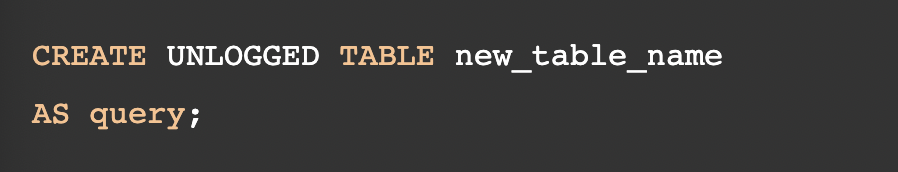

* Unlogged table are kind of disposable table. 
So, if a failover happens, then unlogged tables will never be replicated to secondary server.

UNLIKE temporary tables, unlogged tables are not dropped at the end of a session or the current transaction. Under normal operation, they are infact persistant and operate normally- but faster.

#### Performance comparision of Permanent, Temporary and Unlogged table

CREATE TABLE t_norm( pk int GENERATED ALWAYS AS IDENTITY,
                  t text,
                  primary key( pk ) );

CREATE UNLOGGED TABLE 
           t_unlogged( like t_norm including all );

CREATE TEMPORARY TABLE 
           t_temp( like t_norm including all );
           

\timing;
INSERT INTO t_norm( t )
               SELECT 'Row #' || v
               FROM generate_series( 1, 1000000 ) v;


INSERT INTO t_temp( t )
            SELECT 'Row #' || v
            FROM generate_series( 1, 1000000 ) v;


INSERT INTO t_unlogged( t )
               SELECT 'Unlogged #' || v
               FROM generate_series( 1, 1000000 ) v;

##### Bonus: 
1. GENERATED ALWAYS AS IDENTITY is a constraint to create the identity column for a table.
- The GENERATED AS IDENTITY constraint is the SQL standard-confirming variant of the postgreSQL's SERIAL column.

For more information on identity column, visit https://www.postgresqltutorial.com/postgresql-identity-column/

2. CREATE UNLOGGED TABLE 
           t_unlogged( like t_norm including all );
In the above command, we are inheriting the structure of the t_norm table. 
The LIKE clause specifies a table from which the new table automaticall copies all column names, their data types.

INCLUDING ALL is an abbreviated form of INCLUDING DEFAULTS, INCLUDING CONSTRAINTS,and  INCLUDING INDEXES

As you can see, timings for temporary and unlogged tables are less than permanent table, and this is because both are not inserted into WAL records and therefore there is no crash-recovery machinary involved.

This also means that writing transactions against temporary and unlogged tables is much faster against those tables

Reports suggest that performance improvement is in range from 10% to more than 90%.;

Keep in mind that "unreliable" does not mean that information will be corrupted. It means that data will be lost after a crash.

When to go Unlogged:

1. Large data sets that takes a lot of time to import and are used only a couple of times (finance)

2. Static data that you can afford losing and re-importing in the unlikely event of a server crash.

In [ ]:
query = """SELECT * from t_unlogged"""
sqlio.read_sql_query(query,conn)

In [ ]:
query = """SELECT * from t_norm;"""
sqlio.read_sql_query(query,conn)

In [ ]:
query = """SELECT * from t_temp"""
sqlio.read_sql_query(query,conn)

#### Making an Existing table Logged/Unlogged

Set an unlogged to logged (Permamnent table). Following command is used:
    
    alter table t_unlogged set logged;

Similarly, If the table already exists, and you want to make it UNLOGGED. set the UNLOGGED flag.
alter table t_unlogged set unlogged;

alter table <table_name> set unlogged;

#### Listing UNLOGGED Table

In [ ]:
query = """SELECT relname FROM pg_class WHERE relpersistence = 'u';"""
sqlio.read_sql_query(query,conn)

Unlogged tables are a fast alternative to permanent and temporary tables. 

However, this performance increase comes at the expense of losing data in the event of a server crash, which is something you may be able to afford under certain circumstances.

### Comparing Two tables

There are several ways to compare the content of two table:
1. Compare two tables using EXCEPT and UNION operators
2. Compare two table using OUTER JOIN

#### Create two new tables having the same structre

-- Compare two tables
-- 1st method

CREATE TABLE table_comp_1 (
	ID INT PRIMARY KEY,
	NAME VARCHAR (50)
);


INSERT INTO table_comp_1 (ID, NAME)
VALUES
	(1, 'a'),
	(2, 'b');

CREATE TABLE table_comp_2 (
	ID INT PRIMARY KEY,
	NAME VARCHAR (50)
);

INSERT INTO table_comp_2 (ID, NAME)
VALUES
	(1, 'a'),
	(2, 'b');

In [ ]:
query = """SELECT * from table_comp_1"""
sqlio.read_sql_query(query,conn)

In [ ]:
query = """SELECT * from table_comp_2"""
sqlio.read_sql_query(query,conn)

#### Update one row of the table "table_comp_2"
UPDATE table_comp_2
SET name = 'c'
WHERE
	id = 2;

In [ ]:
query = """SELECT * from table_comp_2"""
sqlio.read_sql_query(query,conn)

Find the rows that are in table_comp_1 but not in table_comp_2

In [ ]:
query = """SELECT ID, NAME FROM table_comp_1
    EXCEPT
    SELECT ID,NAME FROM table_comp_2;"""
sqlio.read_sql_query(query,conn)

In [ ]:
query = """SELECT ID, NAME, 'not in table_comp_2' AS note
    FROM table_comp_1
    EXCEPT
    SELECT ID,NAME, 'not in table_comp_2' AS note 
    FROM table_comp_2;"""
sqlio.read_sql_query(query,conn)

Similarly, Find the rows that are in table_comp_2 but not in table_comp_1

In [ ]:
query = """SELECT ID, NAME, 'not in table_comp_1' AS note
    FROM table_comp_2
    EXCEPT
    SELECT ID,NAME, 'not in table_comp_2' AS note 
    FROM table_comp_1;"""
sqlio.read_sql_query(query,conn)

Use the Union operator to combine the above results

In [ ]:
query = """SELECT ID, NAME, 'not in table_comp_1' AS note
    FROM table_comp_2
    EXCEPT
    SELECT ID,NAME, 'not in table_comp_1' AS note 
    FROM table_comp_1
    UNION
    SELECT ID, NAME, 'not in table_comp_2' AS note
    FROM table_comp_1
    EXCEPT
    SELECT ID,NAME, 'not in table_comp_2' AS note 
    FROM table_comp_2
    ;"""
sqlio.read_sql_query(query,conn)

Compare two tables using OUTER JOIN

In [ ]:
query = """SELECT  table_comp_1.id,  table_comp_1.name,
        table_comp_2.id,  table_comp_2.name 
            FROM table_comp_1
        FULL OUTER JOIN table_comp_2 USING (id, name)
        ;"""
sqlio.read_sql_query(query,conn)

In [ ]:
query = """SELECT id, name FROM table_comp_1
        FULL OUTER JOIN table_comp_2 USING (id, name)
        WHERE table_comp_1.id IS NULL
        OR table_comp_2.id IS NULL;"""
sqlio.read_sql_query(query,conn)

To find the number of rows that are in the table_comp_1 table but not table_comp_2 table and vice versa,

In [ ]:
query = """SELECT count(*) FROM table_comp_1
        FULL OUTER JOIN table_comp_2 USING (id, name)
        WHERE table_c
        OR table_comp_2.id IS NULL;"""
sqlio.read_sql_query(query,conn)

To find the number of rows that are in the table_comp_2 table but not table_comp_1 table.

In [ ]:
query = """SELECT count(*) FROM table_comp_1
        FULL OUTER JOIN table_comp_2 USING (id, name)
        WHERE table_comp_1.id IS NULL;"""
sqlio.read_sql_query(query,conn)

### Delete Duplicate rows 

For demo, execute following command:

DROP TABLE IF EXISTS basket;

CREATE TABLE basket(
    id SERIAL PRIMARY KEY,
    fruit VARCHAR(50) NOT NULL
);

INSERT INTO basket(fruit) values('apple');
INSERT INTO basket(fruit) values('apple');

INSERT INTO basket(fruit) values('orange');
INSERT INTO basket(fruit) values('orange');
INSERT INTO basket(fruit) values('orange');

INSERT INTO basket(fruit) values('banana');

In [3]:
query = """SELECT * FROM basket;"""
sqlio.read_sql_query(query,conn)

,id,fruit
0,1,apple
1,2,apple
2,3,orange
3,4,orange
4,5,orange
5,6,banana


1. Count the number of duplicate rows

In [4]:
query = """SELECT fruit, count(fruit) FROM basket
        group by fruit having count(fruit)>1
        order by fruit
;"""
sqlio.read_sql_query(query,conn)

,fruit,count
0,apple,2
1,orange,3


Delete the duplicate rows and keeps the highest id.

query = """DELETE FROM
    basket a
        USING basket b
WHERE
    a.id < b.id
    AND a.fruit = b.fruit;
"""
sqlio.read_sql_query(query,conn)

#### Generate a random number in a range:

PostgreSQL provides the random() function that returns a number between 0 (inclusive) and 1 (exclusive).

In [5]:
query = """SELECT random();"""
sqlio.read_sql_query(query,conn)

,random
0,0.952544


- Use the setseed function to set the seed for the random function.

In [6]:
query = """SELECT setseed(0.5);"""
sqlio.read_sql_query(query,conn)

,setseed
0,


In [10]:
query = """SELECT random();"""
sqlio.read_sql_query(query,conn)

,random
0,0.227737


To generate a random decimal number between two values:

SELECT random()*(b-a)+a;
here, a- smallest number
b- largest number

##### Generate a random number between 0 and 10.

In [13]:
query = """SELECT random()*(10-0)+0 ;"""
sqlio.read_sql_query(query,conn)

,?column?
0,1.245777


##### Random Integer Range

Note: 
The following cell is not giving expected result. 
execute in pgadmin4/dbeaver for right result

In [14]:
query = """SELECT floor(random()*(25-10))+ 10;"""
sqlio.read_sql_query(query,conn)

,?column?
0,14.0


#### Generate series in Postgres:

There are times within Postgres where you may want to generate sample data or some consistent series of records to join in order for reporting.

**generate_series** as the name implies allows you to generate a set of data starting at some point, ending at another point, and optionally set the incrementing value. 


Syntex:

    generate_series([start], [stop], [{optional}step/interval]);

In [16]:
query = """SELECT * from 
        generate_series(10,20, 2);"""
sqlio.read_sql_query(query,conn)

,generate_series
0,10
1,12
2,14
3,16
4,18
5,20


In [ ]:
One of the Use case of generate series: Generate fake data

In [17]:
# using generate_series function with CTE
query = """WITH numbers AS (
          SELECT *
          FROM generate_series(1, 5)
        )
        SELECT generate_series * random()
        FROM numbers;
        
        ;"""
sqlio.read_sql_query(query,conn)

,?column?
0,0.146961
1,1.267277
2,0.468232
3,3.925007
4,3.801236


Generate series of months

In [19]:
query = """select DATE'2022-01-01' 
    - (interval '1' month * generate_series(0,11)) as month;;
        
        ;"""
sqlio.read_sql_query(query,conn)

,month
0,2022-01-01
1,2021-12-01
2,2021-11-01
3,2021-10-01
4,2021-09-01
5,2021-08-01
6,2021-07-01
7,2021-06-01
8,2021-05-01
9,2021-04-01


generate series of dates

In [20]:
query = """SELECT 
generate_series(date '2010-03-07', '2010-08-16', '1 day')::date AS day
        
        ;"""
sqlio.read_sql_query(query,conn)

,day
0,2010-03-07
1,2010-03-08
2,2010-03-09
3,2010-03-10
4,2010-03-11
...,...
158,2010-08-12
159,2010-08-13
160,2010-08-14
161,2010-08-15


In [21]:
query = """select generate_series(
      date_trunc('hour', now()) - '1 day'::interval,
      date_trunc('hour', now()),
      '1 hour'::interval 
        ) as hour;"""
sqlio.read_sql_query(query,conn)

,hour
0,2022-03-07 08:30:00+00:00
1,2022-03-07 09:30:00+00:00
2,2022-03-07 10:30:00+00:00
3,2022-03-07 11:30:00+00:00
4,2022-03-07 12:30:00+00:00
5,2022-03-07 13:30:00+00:00
6,2022-03-07 14:30:00+00:00
7,2022-03-07 15:30:00+00:00
8,2022-03-07 16:30:00+00:00
9,2022-03-07 17:30:00+00:00


The above query generates hours between now and yesterday. 

date_trunc(): this function helps in extracting specific portion of date and time.

#### PostgreSQL Windows functions

The basic purpose of the an analytic or a window function is to perform calculations across several records related to the current row. 

It takes into account the context of the current row and calculates other rows based on that.

The window function can be considered similar to aggregate functions.

The major diffrance between these is that an aggregate function group the number of output records, whereas a window function does not group the output records to a single row.

Some of the popular analytic function in Postgres are as follows:

1. CUME_DIST: return the relative rank of the current row.
2. Dense Rank: Rank the current row within its partition without gaps
3. FIRST_VALUE: find the first value that appears in a group of records within the dataset
4. LAST_VALUE: find the last value that appears within a group of records
5. RANK: Rank the current row within its partition with gaps
6. LAG: displays values after the occurance of the current row.
7. LEAD:displays values that appear before the occurance of the current row.


Note that some aggregate functions such as AVG(), MIN(), MAX(), SUM(), and COUNT() can be also used as window functions.

CREATE TABLE laptops(
	laptop_id		SERIAL,
	laptop_name		VARCHAR(100),
	laptop_brand	VARCHAR(100),
	relesed_year	INT,
	device_type		VARCHAR(100),
	price			DECIMAL(9,2)
);

INSERT INTO laptops (laptop_name,laptop_brand,relesed_year,device_type,price) VALUES
('Microsoft Surface Laptop 4 15-inch','Microsoft',2017,'Office',130),
('Microsoft Surface Pro 7+','Microsoft',2019,'Office',140),
('Apple MacBook Air (M1, 2020)','Apple',2020,'Business',90),
('Apple MacBook Air MREA2HN/A','Apple',2021,'Business',100),
('Dell XPS 13 9310','Dell',2021,'Office',150),
('Dell XPS 15 9500','Dell',2021,'Gaming',200),
('Dell G5 15 SE 5505','Dell',2020,'Business',75),
('HP Chromebook 11a','HP',2020,'Business',20);

In [23]:
query = """Select * from laptops;"""
sqlio.read_sql_query(query,conn)

,laptop_id,laptop_name,laptop_brand,relesed_year,device_type,price
0,1,Microsoft Surface Laptop 4 15-inch,Microsoft,2017,Office,130.0
1,2,Microsoft Surface Pro 7+,Microsoft,2019,Office,140.0
2,3,"Apple MacBook Air (M1, 2020)",Apple,2020,Business,90.0
3,4,Apple MacBook Air MREA2HN/A,Apple,2021,Business,100.0
4,5,Dell XPS 13 9310,Dell,2021,Office,150.0
5,7,Dell G5 15 SE 5505,Dell,2020,Business,75.0
6,8,HP Chromebook 11a,HP,2020,Business,20.0
7,6,Dell XPS 15 9500,Dell,2021,Gaming,150.0
8,9,Dell XPS 15 9501,Dell,2021,Gaming,180.0


In [24]:
query = """ Select laptop_brand, AVG(price)
            from laptops
            group by laptop_brand;
            
            """
sqlio.read_sql_query(query,conn)

,laptop_brand,avg
0,Microsoft,135.00
1,Dell,138.75
2,HP,20.00
3,Apple,95.00


#### ROW_NUMBER

In [29]:
query = """ Select laptop_name, laptop_brand, price,
            ROW_NUMBER() OVER 
            (PARTITION BY laptop_brand ORDER BY price) AS rank_laptop_brand
            from laptops;"""
sqlio.read_sql_query(query,conn)

,laptop_name,laptop_brand,price,rank_laptop_brand
0,"Apple MacBook Air (M1, 2020)",Apple,90.0,1
1,Apple MacBook Air MREA2HN/A,Apple,100.0,2
2,Dell G5 15 SE 5505,Dell,75.0,1
3,Dell XPS 15 9500,Dell,150.0,2
4,Dell XPS 13 9310,Dell,150.0,3
5,Dell XPS 15 9501,Dell,180.0,4
6,HP Chromebook 11a,HP,20.0,1
7,Microsoft Surface Laptop 4 15-inch,Microsoft,130.0,1
8,Microsoft Surface Pro 7+,Microsoft,140.0,2


In the above query, records are ranked by prices. and the partition is created on the laptop_brand colum. This means the rank will reset to 1 and and start again for every change in the laptop_brand column.

PARTITION BY:
an optional clause that divides rows into multiple partitions where the function is applied.If not set, postgreSQL treats the whole result set as a single partition.

#### RANK Function()
- Rank the current row within its partition with gaps

- This function assigns a rank or assign a row number to every row within a partition of a result set. 
- This rank is set to 1 for the first row in each partition. 
As the partition changes, the RANK automatically detects the change and assigns the value to that row.

In [30]:
query = """ Select laptop_name, laptop_brand, price,
            RANK() OVER 
            (PARTITION BY laptop_brand ORDER BY price) AS rank_laptop_brand
            from laptops;"""
sqlio.read_sql_query(query,conn)

,laptop_name,laptop_brand,price,rank_laptop_brand
0,"Apple MacBook Air (M1, 2020)",Apple,90.0,1
1,Apple MacBook Air MREA2HN/A,Apple,100.0,2
2,Dell G5 15 SE 5505,Dell,75.0,1
3,Dell XPS 15 9500,Dell,150.0,2
4,Dell XPS 13 9310,Dell,150.0,2
5,Dell XPS 15 9501,Dell,180.0,4
6,HP Chromebook 11a,HP,20.0,1
7,Microsoft Surface Laptop 4 15-inch,Microsoft,130.0,1
8,Microsoft Surface Pro 7+,Microsoft,140.0,2


The RANK function assigns ranking within an ordered partition. If rows have same values, the RANK() function assigns the same RANK, with the next ranking(s) skipped.

##### DENSE RANK:   

- Similar to RANK() function, the DENSE RANK() function assigns a rank to each row within an ordered partition, but the ranks have no gap.
    
- In other words, the same ranks are assigned to multiple rows and no rows are skipped.

In [31]:
query = """ Select laptop_name, laptop_brand,price,
            DENSE_RANK() OVER 
            (PARTITION BY laptop_brand ORDER BY price) AS rank_laptop_brand
            from laptops;"""
sqlio.read_sql_query(query,conn)

,laptop_name,laptop_brand,price,rank_laptop_brand
0,"Apple MacBook Air (M1, 2020)",Apple,90.0,1
1,Apple MacBook Air MREA2HN/A,Apple,100.0,2
2,Dell G5 15 SE 5505,Dell,75.0,1
3,Dell XPS 15 9500,Dell,150.0,2
4,Dell XPS 13 9310,Dell,150.0,2
5,Dell XPS 15 9501,Dell,180.0,3
6,HP Chromebook 11a,HP,20.0,1
7,Microsoft Surface Laptop 4 15-inch,Microsoft,130.0,1
8,Microsoft Surface Pro 7+,Microsoft,140.0,2


CUME_DIST:
This function returns a double-precision value between 0 and 1:

0 < CUME_DIST() <= 1

In [32]:
query = """ Select laptop_name, laptop_brand,price,
            CUME_DIST() OVER 
            (PARTITION BY laptop_brand ORDER BY price) AS rank_laptop_brand
            from laptops;"""
sqlio.read_sql_query(query,conn)

,laptop_name,laptop_brand,price,rank_laptop_brand
0,"Apple MacBook Air (M1, 2020)",Apple,90.0,0.50
1,Apple MacBook Air MREA2HN/A,Apple,100.0,1.00
2,Dell G5 15 SE 5505,Dell,75.0,0.25
3,Dell XPS 15 9500,Dell,150.0,0.75
4,Dell XPS 13 9310,Dell,150.0,0.75
5,Dell XPS 15 9501,Dell,180.0,1.00
6,HP Chromebook 11a,HP,20.0,1.00
7,Microsoft Surface Laptop 4 15-inch,Microsoft,130.0,0.50
8,Microsoft Surface Pro 7+,Microsoft,140.0,1.00


Understanding the above result:
- 50% of the laptop of brand Apple have price less than or equal to 90.0

##### FIRST_VALUE():
finds the first value that appears in a group of records within the dataset
##### LAST_VALUE: 
finds the last value that appears within a group of records

In [48]:
query = """ Select laptop_name, laptop_brand,
            FIRST_VALUE(price) OVER 
            (PARTITION BY laptop_brand order by price) AS lowest_price_per_group
            from laptops;"""
sqlio.read_sql_query(query,conn)

,laptop_name,laptop_brand,lowest_price_per_group
0,"Apple MacBook Air (M1, 2020)",Apple,90.0
1,Apple MacBook Air MREA2HN/A,Apple,90.0
2,Dell G5 15 SE 5505,Dell,75.0
3,Dell XPS 15 9500,Dell,75.0
4,Dell XPS 13 9310,Dell,75.0
5,Dell XPS 15 9501,Dell,75.0
6,HP Chromebook 11a,HP,20.0
7,Microsoft Surface Laptop 4 15-inch,Microsoft,130.0
8,Microsoft Surface Pro 7+,Microsoft,130.0


In [49]:
### alternative
query = """Select laptop_name, laptop_brand, price,
           min(price) OVER 
           (PARTITION BY laptop_brand ORDER BY laptop_brand) AS avg_price
           from laptops;"""
sqlio.read_sql_query(query,conn)

,laptop_name,laptop_brand,price,avg_price
0,"Apple MacBook Air (M1, 2020)",Apple,90.0,90.0
1,Apple MacBook Air MREA2HN/A,Apple,100.0,90.0
2,Dell XPS 15 9501,Dell,180.0,75.0
3,Dell XPS 13 9310,Dell,150.0,75.0
4,Dell G5 15 SE 5505,Dell,75.0,75.0
5,Dell XPS 15 9500,Dell,150.0,75.0
6,HP Chromebook 11a,HP,20.0,20.0
7,Microsoft Surface Pro 7+,Microsoft,140.0,130.0
8,Microsoft Surface Laptop 4 15-inch,Microsoft,130.0,130.0


Below query also prints the laptop_name in each row for which price is lowest. (without partition)

In [50]:
query = """ Select laptop_name, laptop_brand, price,
            FIRST_VALUE(laptop_name) OVER 
            (ORDER BY price) AS lowest_price_per_group
            from laptops;"""
sqlio.read_sql_query(query,conn)

,laptop_name,laptop_brand,price,lowest_price_per_group
0,HP Chromebook 11a,HP,20.0,HP Chromebook 11a
1,Dell G5 15 SE 5505,Dell,75.0,HP Chromebook 11a
2,"Apple MacBook Air (M1, 2020)",Apple,90.0,HP Chromebook 11a
3,Apple MacBook Air MREA2HN/A,Apple,100.0,HP Chromebook 11a
4,Microsoft Surface Laptop 4 15-inch,Microsoft,130.0,HP Chromebook 11a
5,Microsoft Surface Pro 7+,Microsoft,140.0,HP Chromebook 11a
6,Dell XPS 13 9310,Dell,150.0,HP Chromebook 11a
7,Dell XPS 15 9500,Dell,150.0,HP Chromebook 11a
8,Dell XPS 15 9501,Dell,180.0,HP Chromebook 11a


In [51]:
### similarly,
query = """ Select laptop_name, laptop_brand, price,
            min(price) OVER 
            (ORDER BY laptop_brand) AS avg_price
            from laptops;"""
sqlio.read_sql_query(query,conn)

,laptop_name,laptop_brand,price,avg_price
0,"Apple MacBook Air (M1, 2020)",Apple,90.0,90.0
1,Apple MacBook Air MREA2HN/A,Apple,100.0,90.0
2,Dell XPS 15 9501,Dell,180.0,75.0
3,Dell XPS 13 9310,Dell,150.0,75.0
4,Dell G5 15 SE 5505,Dell,75.0,75.0
5,Dell XPS 15 9500,Dell,150.0,75.0
6,HP Chromebook 11a,HP,20.0,20.0
7,Microsoft Surface Pro 7+,Microsoft,140.0,20.0
8,Microsoft Surface Laptop 4 15-inch,Microsoft,130.0,20.0


In [ ]:
Print the highest price per group ordered by laptop_brand

In [54]:
query = """ Select laptop_name, laptop_brand, price,
            LAST_VALUE(price) OVER 
            (PARTITION BY laptop_brand ORDER BY laptop_brand) AS highest_price_per_group
            from laptops;"""
sqlio.read_sql_query(query,conn)

,laptop_name,laptop_brand,price,highest_price_per_group
0,"Apple MacBook Air (M1, 2020)",Apple,90.0,100.0
1,Apple MacBook Air MREA2HN/A,Apple,100.0,100.0
2,Dell XPS 15 9501,Dell,180.0,150.0
3,Dell XPS 13 9310,Dell,150.0,150.0
4,Dell G5 15 SE 5505,Dell,75.0,150.0
5,Dell XPS 15 9500,Dell,150.0,150.0
6,HP Chromebook 11a,HP,20.0,20.0
7,Microsoft Surface Pro 7+,Microsoft,140.0,130.0
8,Microsoft Surface Laptop 4 15-inch,Microsoft,130.0,130.0


How Window functions are diffrent from GROUP BY function?

- Window functions do aggregarions similar to GROUP BY clause.
- However, rows are not grouped into a single row, instead, each row retains its seperate identity.
- A window function may return a single value for each row.

#### Usage of LEAD and LAG functions

LAG: has the ability to access data from the previous row.

In [38]:
# LEAD() with partition
query = """ Select laptop_name, laptop_brand, price,
            lead(price,1) OVER 
            (PARTITION BY laptop_brand ORDER BY price) AS next_price
            from laptops;"""
sqlio.read_sql_query(query,conn)

,laptop_name,laptop_brand,price,next_price
0,"Apple MacBook Air (M1, 2020)",Apple,90.0,100.0
1,Apple MacBook Air MREA2HN/A,Apple,100.0,NaN
2,Dell G5 15 SE 5505,Dell,75.0,150.0
3,Dell XPS 15 9500,Dell,150.0,150.0
4,Dell XPS 13 9310,Dell,150.0,180.0
5,Dell XPS 15 9501,Dell,180.0,NaN
6,HP Chromebook 11a,HP,20.0,NaN
7,Microsoft Surface Laptop 4 15-inch,Microsoft,130.0,140.0
8,Microsoft Surface Pro 7+,Microsoft,140.0,NaN


In [39]:
# LEAD without partition
query = """ Select laptop_name, laptop_brand, price,
            lead(price,1) OVER 
            (ORDER BY price) AS next_price
            from laptops;"""
sqlio.read_sql_query(query,conn)

,laptop_name,laptop_brand,price,next_price
0,HP Chromebook 11a,HP,20.0,75.0
1,Dell G5 15 SE 5505,Dell,75.0,90.0
2,"Apple MacBook Air (M1, 2020)",Apple,90.0,100.0
3,Apple MacBook Air MREA2HN/A,Apple,100.0,130.0
4,Microsoft Surface Laptop 4 15-inch,Microsoft,130.0,140.0
5,Microsoft Surface Pro 7+,Microsoft,140.0,150.0
6,Dell XPS 13 9310,Dell,150.0,150.0
7,Dell XPS 15 9500,Dell,150.0,180.0
8,Dell XPS 15 9501,Dell,180.0,NaN


LEAD() function can access data from the next row.

In [40]:
# LAG with partition
query = """ Select laptop_name, laptop_brand, price,
            lag(price,1) OVER 
            (PARTITION BY laptop_brand ORDER BY price) AS next_price
            from laptops;"""
sqlio.read_sql_query(query,conn)

,laptop_name,laptop_brand,price,next_price
0,"Apple MacBook Air (M1, 2020)",Apple,90.0,NaN
1,Apple MacBook Air MREA2HN/A,Apple,100.0,90.0
2,Dell G5 15 SE 5505,Dell,75.0,NaN
3,Dell XPS 15 9500,Dell,150.0,75.0
4,Dell XPS 13 9310,Dell,150.0,150.0
5,Dell XPS 15 9501,Dell,180.0,150.0
6,HP Chromebook 11a,HP,20.0,NaN
7,Microsoft Surface Laptop 4 15-inch,Microsoft,130.0,NaN
8,Microsoft Surface Pro 7+,Microsoft,140.0,130.0


In [41]:
# lag without partition
query = """ Select laptop_name, laptop_brand, price,
            lag(price,2) OVER 
            (ORDER BY price) AS next_price
            from laptops;"""
sqlio.read_sql_query(query,conn)

,laptop_name,laptop_brand,price,next_price
0,HP Chromebook 11a,HP,20.0,NaN
1,Dell G5 15 SE 5505,Dell,75.0,NaN
2,"Apple MacBook Air (M1, 2020)",Apple,90.0,20.0
3,Apple MacBook Air MREA2HN/A,Apple,100.0,75.0
4,Microsoft Surface Laptop 4 15-inch,Microsoft,130.0,90.0
5,Microsoft Surface Pro 7+,Microsoft,140.0,100.0
6,Dell XPS 13 9310,Dell,150.0,130.0
7,Dell XPS 15 9500,Dell,150.0,140.0
8,Dell XPS 15 9501,Dell,180.0,150.0


In [ ]:
# Delete duplicate rows

In [ ]:
# first create a new table 'laptop_demo' having the same structure as laptop

##### command to create a new table
1. Permanent table
CREATE table laptop_demo AS  
TABLE laptops;

2. Unlogged table
CREATE unlogged table  laptop_demo1 AS  
TABLE laptops;

drop table laptop_demo1;

In [42]:
query = """ Select laptop_name, laptop_brand, price,
            ROW_NUMBER() OVER 
            (PARTITION BY laptop_brand ORDER BY price) AS row_num
            from laptop_demo;"""
sqlio.read_sql_query(query,conn)

,laptop_name,laptop_brand,price,row_num
0,"Apple MacBook Air (M1, 2020)",Apple,90.0,1
1,Apple MacBook Air MREA2HN/A,Apple,100.0,2
2,Dell G5 15 SE 5505,Dell,75.0,1
3,Dell XPS 15 9500,Dell,150.0,2
4,Dell XPS 13 9310,Dell,150.0,3
5,Dell XPS 15 9501,Dell,180.0,4
6,HP Chromebook 11a,HP,20.0,1
7,Microsoft Surface Laptop 4 15-inch,Microsoft,130.0,1
8,Microsoft Surface Pro 7+,Microsoft,140.0,2


In [43]:
query = """ select laptop_brand from (
                Select laptop_name, laptop_brand, price,
            ROW_NUMBER() OVER 
            (PARTITION BY laptop_brand ORDER BY price) AS row_num
            from laptop_demo) t
            where row_num>1;"""
sqlio.read_sql_query(query,conn)

,laptop_brand
0,Apple
1,Dell
2,Dell
3,Dell
4,Microsoft


In [ ]:
query = """DELETE FROM laptop_demo WHERE laptop_brand IN (
            SELECT 
            laptop_brand FROM (
                Select laptop_name, laptop_brand, price,
            ROW_NUMBER() OVER 
            (PARTITION BY laptop_brand ORDER BY price) AS row_num
            from laptop_demo) t
    WHERE row_num > 1);"""

sqlio.read_sql_query(query,conn)

DELETE FROM contacts 
WHERE id IN (SELECT id FROM 
             (SELECT id,ROW_NUMBER() 
              OVER (PARTITION BY email ORDER BY email) AS row_num
            FROM 
    contacts
) t
    WHERE row_num > 1
);

##### EXPLAIN Statement:

- If you have an SQL statement that executes slowly, and you want to know what is going on and how to fix it. 
- This statement is used to display the execution plan of a statement that is generated by the optimizer
- It shows how tables involved in a statement will be scanned by index scan or sequential scan etc and if multiple tables are used, what kind of join algorithm will be used.

It helps you to look even closer into an indiviual query.

To read more about EXPLAIN Command, visit https://www.postgresqltutorial.com/postgresql-explain/

https://www.cybertec-postgresql.com/en/how-to-interpret-postgresql-explain-analyze-output/

Website to understand the PostgreSQL's explain analyze output:
1. https://explain.depesz.com
2. https://explain.dalibo.com/

In [ ]:
PostgreSQL vs MySQL